In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-radiation-rajasthan/BA_Combined.xlsx


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load dataset
data_path = "../input/solar-radiation-rajasthan/BA_Combined.xlsx"
df = pd.read_excel(data_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               43800 non-null  int64  
 1   Month              43800 non-null  int64  
 2   Day                43800 non-null  int64  
 3   Hour               43800 non-null  int64  
 4   Minute             43800 non-null  int64  
 5   DHI                43800 non-null  int64  
 6   DNI                43800 non-null  int64  
 7   GHI                43800 non-null  int64  
 8   Dew Point          43800 non-null  int64  
 9   Temperature        43800 non-null  float64
 10  Pressure           43800 non-null  float64
 11  Relative Humidity  43800 non-null  float64
 12  Wind Direction     43800 non-null  float64
 13  Wind Speed         43800 non-null  float64
dtypes: float64(5), int64(9)
memory usage: 4.7 MB
None
              Year         Month           Day          Hour   Minut

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


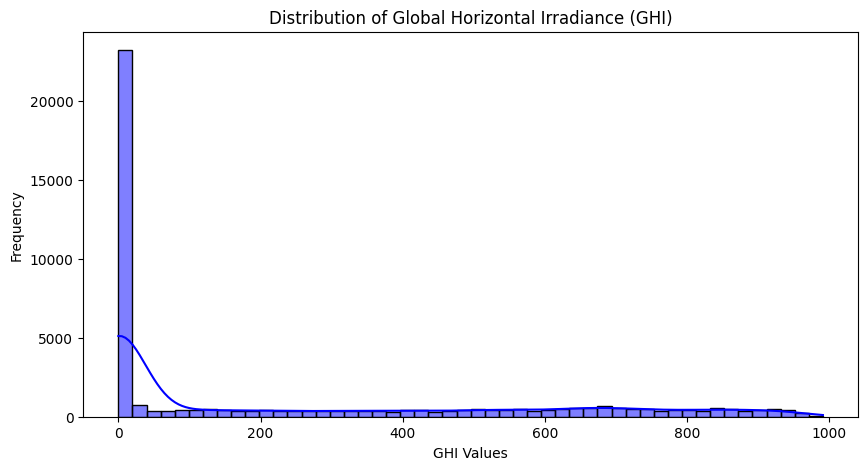

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


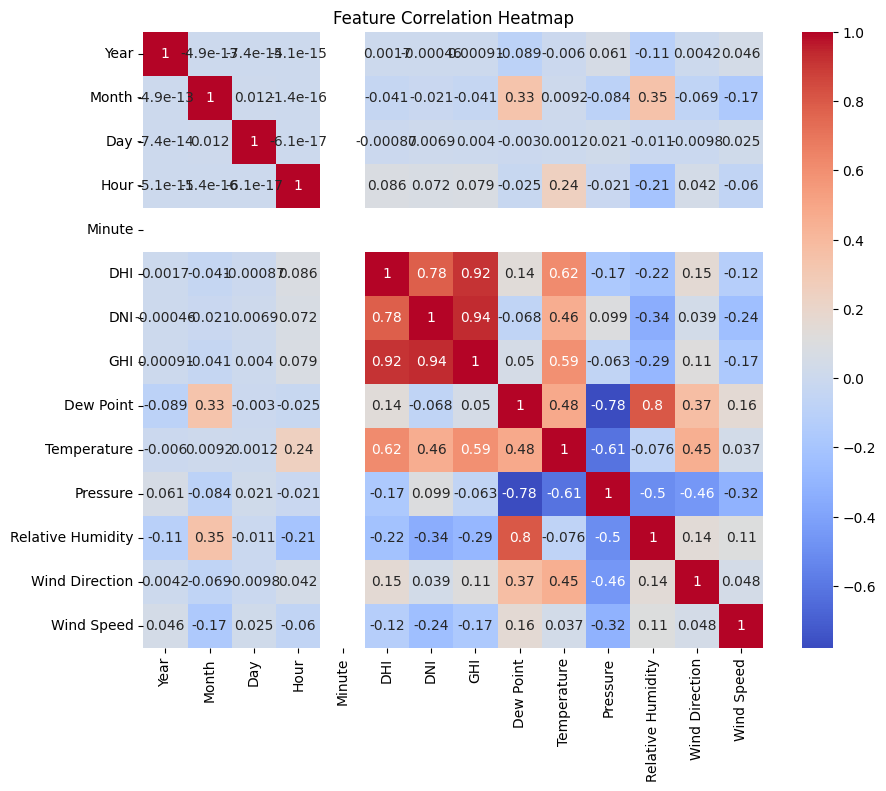

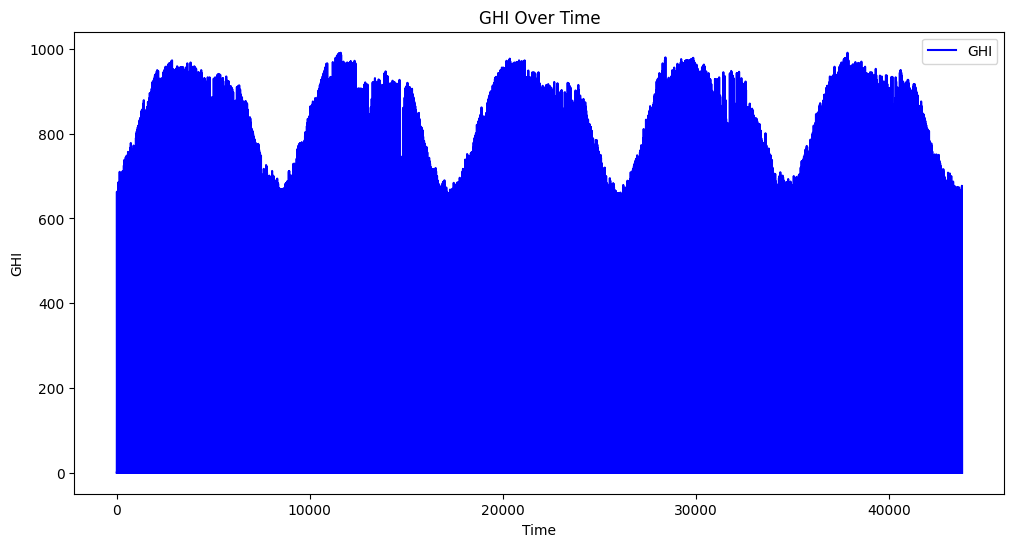

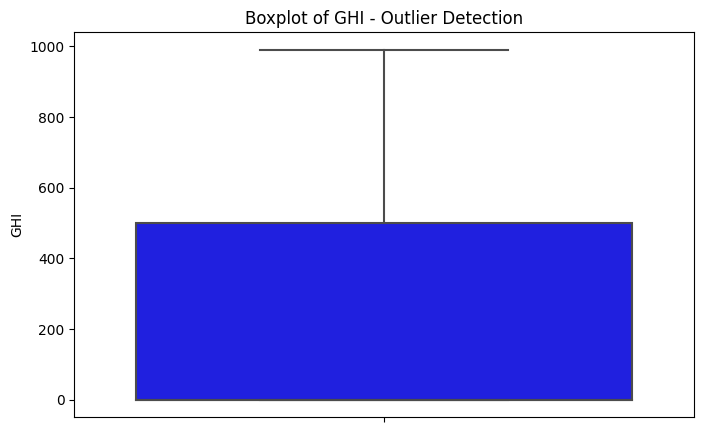

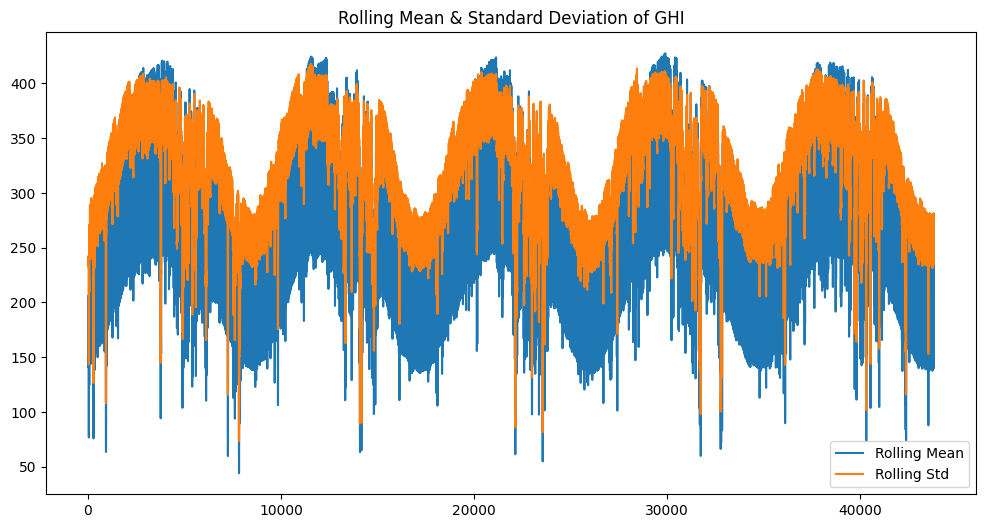

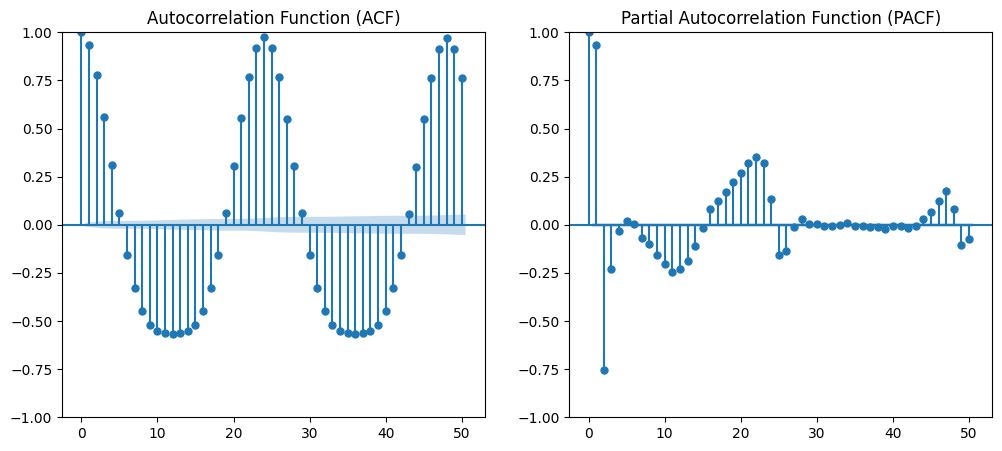

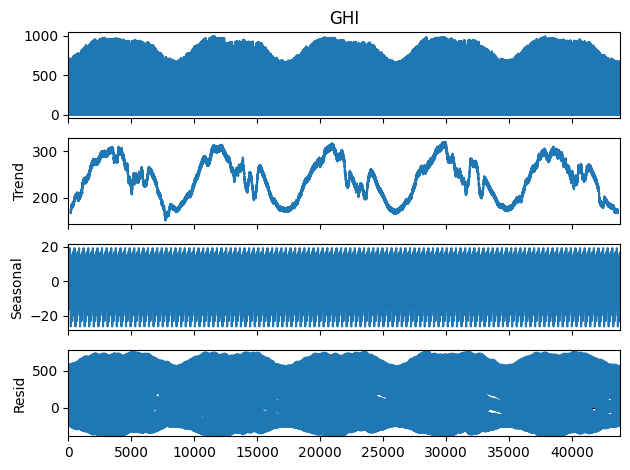

In [3]:
# Display basic information
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check for missing values

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# EDA - Visualization
plt.figure(figsize=(10,5))
sns.histplot(df['GHI'], bins=50, kde=True, color='blue')
plt.title("Distribution of Global Horizontal Irradiance (GHI)")
plt.xlabel("GHI Values")
plt.ylabel("Frequency")
plt.show()

# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['GHI'], label="GHI", color="blue")
plt.title("GHI Over Time")
plt.xlabel("Time")
plt.ylabel("GHI")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(y=df['GHI'], color='blue')
plt.title("Boxplot of GHI - Outlier Detection")
plt.show()

df['GHI'].rolling(window=30).mean().plot(label='Rolling Mean', figsize=(12,6))
df['GHI'].rolling(window=30).std().plot(label='Rolling Std')
plt.title("Rolling Mean & Standard Deviation of GHI")
plt.legend()
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1,2, figsize=(12,5))
plot_acf(df['GHI'], ax=ax[0], lags=50)
ax[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(df['GHI'], ax=ax[1], lags=50)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['GHI'], model='additive', period=365)  
result.plot()
plt.show()





Random Forest - MAE: 2.2428173515981737, MSE: 31.22791248858448, R2 Score: 0.9996835742898165


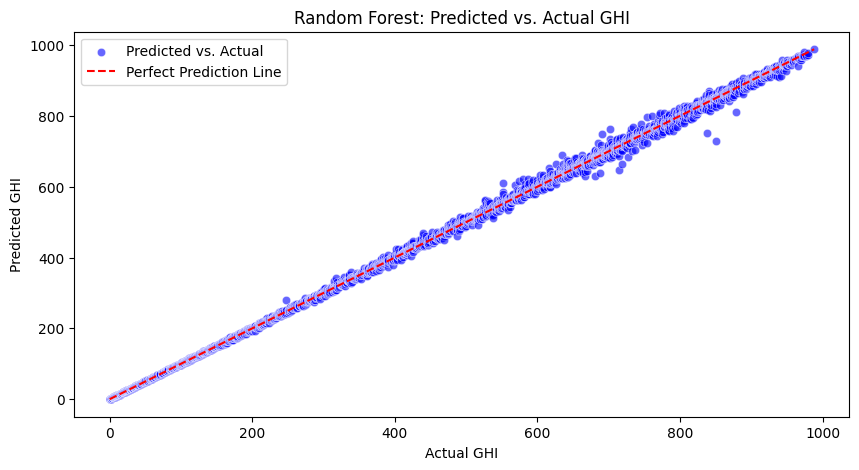

<ipython-input-4-e16f5bd91410>:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=df["DateTime"].max(), periods=90, freq="H")


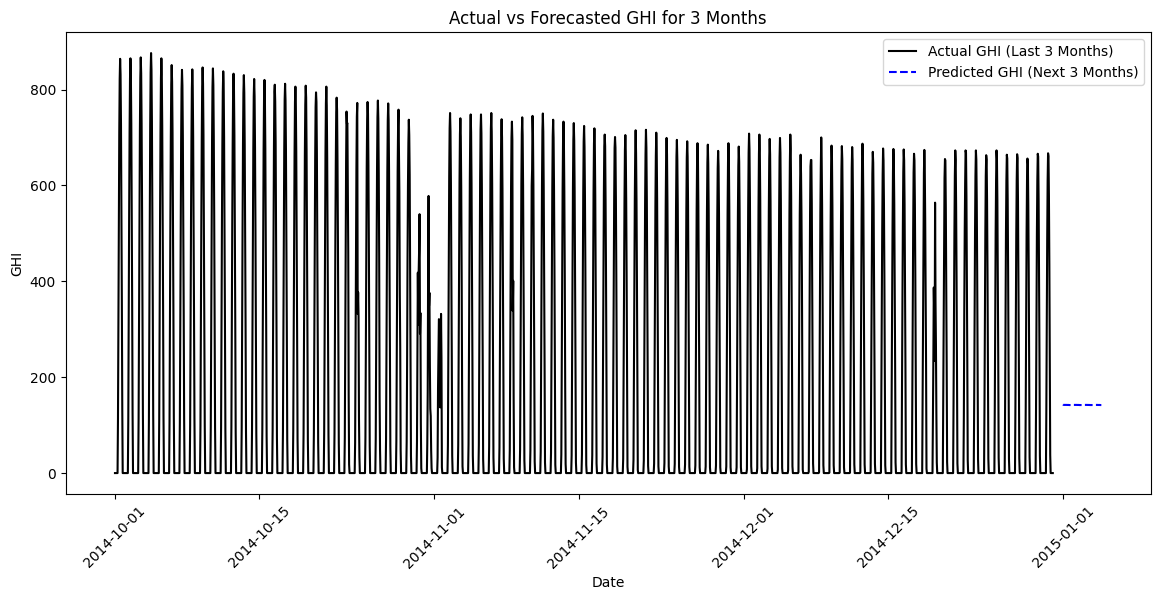

XGBoost - MAE: 2.9003795416970783, MSE: 37.38134902707871, R2 Score: 0.9996212228429346


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA - MAE: 261.12980916514914, MSE: 101727.35352205996, R2 Score: -0.030781359307125777
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2190/2190 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.0193
Epoch 2/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0044
Epoch 3/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0043
Epoch 4/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0041
Epoch 5/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0040
Epoch 6/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0036
Epoch 7/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0037
Epoch 8/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.0038
Epoch 9/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0035
Epoch 10/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0037
Epoch 11/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0034
Epoch 12/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0036
Epoch 13/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0034
Epoch 14/20
2190/2190 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0034
Epoch 15/20
2190/2190 ━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2189/2189 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - loss: 0.0110 - val_loss: 0.0028
Epoch 2/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 3/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 4/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 9/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 43s 20ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 11/50
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 12/50
2189/21

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

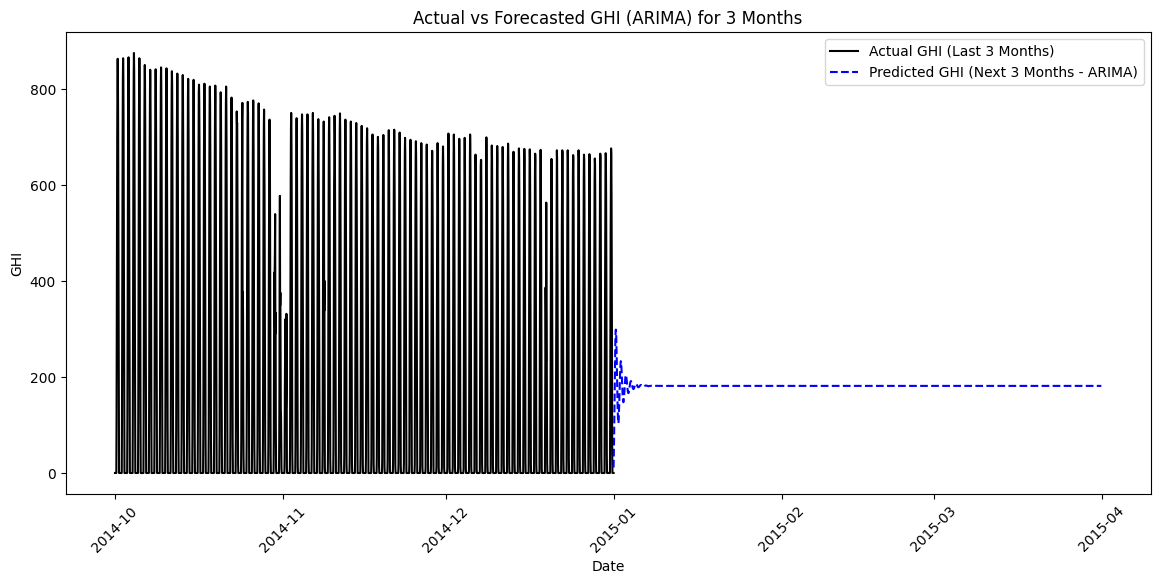

In [4]:
# Prepare feature matrix and target variable
X = df.drop(columns=['GHI'])
y = df['GHI']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model 1: Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R2 Score: {r2_rf}")

#Plot Predicted Vs Actual values using Random Forest
# Sort values for better visualization
sorted_indices = np.argsort(y_test)
y_test_sorted = np.array(y_test)[sorted_indices]
y_pred_sorted = np.array(y_pred_rf)[sorted_indices]

# Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test_sorted, y=y_pred_sorted, alpha=0.6, color="blue", label="Predicted vs. Actual")
plt.plot(y_test_sorted, y_test_sorted, color="red", linestyle="--", label="Perfect Prediction Line")

plt.xlabel("Actual GHI")
plt.ylabel("Predicted GHI")
plt.title("Random Forest: Predicted vs. Actual GHI")
plt.legend()
plt.show()

# ------------------ 3-Month Forecast ------------------ #

# Generate future timestamps (next 3 months)
df["DateTime"] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
# Generate future dates based on the last known timestamp
future_dates = pd.date_range(start=df["DateTime"].max(), periods=90, freq="H")


# Extract date-time features
future_df = pd.DataFrame({
    "Year": future_dates.year,
    "Month": future_dates.month,
    "Day": future_dates.day,
    "Hour": future_dates.hour,
    "Minute": future_dates.minute
})

# Fill other required feature columns (DHI, DNI, Dew Point, etc.)
# Assuming using mean values for now (You can use other logic)
for col in X.columns:
    if col not in ["Year", "Month", "Day", "Hour", "Minute"]:
        future_df[col] = df[col].mean()

# Predict future GHI
future_df["Predicted_GHI"] = rf_model.predict(future_df)
future_df["DateTime"] = future_dates

# ------------------ Get Actual Data for Previous 3 Months ------------------ #
start_date = "2014-10-01"
end_date = "2014-12-31"
actual_df = df[(df["DateTime"] >= start_date) & (df["DateTime"] <= end_date)][["DateTime", "GHI"]]

# ------------------ Plot Actual vs Forecasted ------------------ #
plt.figure(figsize=(14, 6))

# Plot Actual Data
plt.plot(actual_df["DateTime"], actual_df["GHI"], label="Actual GHI (Last 3 Months)", color="black")

# Plot Forecasted Data
plt.plot(future_df["DateTime"], future_df["Predicted_GHI"], label="Predicted GHI (Next 3 Months)", color="blue", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("GHI")
plt.title("Actual vs Forecasted GHI for 3 Months")
plt.legend()
plt.xticks(rotation=45)
plt.show()



### Model 2: XGBoost Regression
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - MAE: {mae_xgb}, MSE: {mse_xgb}, R2 Score: {r2_xgb}")

### Model 3: ARIMA Time Series Forecasting
arima_order = (2,1,5)  # Adjust order based on ACF/PACF analysis
arima_model = ARIMA(y, order=arima_order)
arima_model_fit = arima_model.fit()
y_pred_arima = arima_model_fit.forecast(steps=len(y_test))

# Evaluate ARIMA model
mae_arima = mean_absolute_error(y_test, y_pred_arima)
mse_arima = mean_squared_error(y_test, y_pred_arima)
r2_arima = r2_score(y_test, y_pred_arima)
print(f"ARIMA - MAE: {mae_arima}, MSE: {mse_arima}, R2 Score: {r2_arima}")


### Model 5: LSTM Time Series Forecasting
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

# Prepare LSTM input
X_lstm, y_lstm = [], []
lookback = 10  # Use last 10 days for prediction
for i in range(lookback, len(y_scaled)):
    X_lstm.append(y_scaled[i-lookback:i, 0])
    y_lstm.append(y_scaled[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Reshape for LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback,1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=1)

# Make predictions
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

# Evaluate LSTM model
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
print(f"LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, R2 Score: {r2_lstm}")

### Model 6: Improved LSTM
from tensorflow.keras.callbacks import EarlyStopping

lookback = 20  # Increase lookback to capture longer trends

# Prepare LSTM input data with longer lookback
X_lstm, y_lstm = [], []
for i in range(lookback, len(y_scaled)):
    X_lstm.append(y_scaled[i-lookback:i, 0])
    y_lstm.append(y_scaled[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Reshape for LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Define LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(lookback, 1)),  # Increase LSTM units
    Dropout(0.1),  # Reduce dropout rate
    LSTM(100, return_sequences=False),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Use Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train LSTM
model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm), callbacks=[early_stop], verbose=1)

# Predict
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

# Evaluate LSTM
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)

print(f"Improved LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, R2 Score: {r2_lstm}")


# Compare Model Performance
print("\nModel Performance Summary:")
print(f"Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R2 Score: {r2_rf}")
print(f"XGBoost      - MAE: {mae_xgb}, MSE: {mse_xgb}, R2 Score: {r2_xgb}")
print(f"ARIMA        - MAE: {mae_arima}, MSE: {mse_arima}, R2 Score: {r2_arima}")
print(f"LSTM         - MAE: {mae_lstm}, MSE: {mse_lstm}, R2 Score: {r2_lstm}")


# Forecast next 7 days using LSTM
future_inputs = X_test_lstm[-1].reshape(1, lookback, 1)
predictions = []
for _ in range(7):
    pred = model.predict(future_inputs)
    predictions.append(pred[0,0])
    future_inputs = np.append(future_inputs[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

print("Predicted GHI for next 7 days:", predictions.flatten())

#arima forecast
# Ensure DateTime column is a datetime type
df["DateTime"] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Sort dataframe by DateTime
df = df.sort_values(by="DateTime")

# Set DateTime as index
df.set_index("DateTime", inplace=True)

# Define training data for ARIMA
y = df["GHI"]

# Train ARIMA model
arima_order = (2,1,5)  # Adjust order based on ACF/PACF analysis
arima_model = ARIMA(y, order=arima_order)
arima_model_fit = arima_model.fit()

# Get actual data for the last 3 months
start_date = "2014-10-01"
end_date = "2014-12-31"
actual_df = df.loc[start_date:end_date, ["GHI"]]

# Forecast next 3 months
future_steps = 90 * 24  # Assuming hourly data for 90 days
future_forecast = arima_model_fit.forecast(steps=future_steps)

# Create future dates
future_dates = pd.date_range(start=df.index.max(), periods=future_steps, freq="h")

# Create DataFrame for future predictions
future_df = pd.DataFrame({
    "DateTime": future_dates,
    "Predicted_GHI": future_forecast
})

# ------------------ Plot Actual vs Forecasted ------------------ #
plt.figure(figsize=(14, 6))

# Plot Actual Data (Last 3 Months)
plt.plot(actual_df.index, actual_df["GHI"], label="Actual GHI (Last 3 Months)", color="black")

# Plot Forecasted Data (Next 3 Months)
plt.plot(future_df["DateTime"], future_df["Predicted_GHI"], label="Predicted GHI (Next 3 Months - ARIMA)", color="blue", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("GHI")
plt.title("Actual vs Forecasted GHI (ARIMA) for 3 Months")
plt.legend()
plt.xticks(rotation=45)
plt.show()





/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

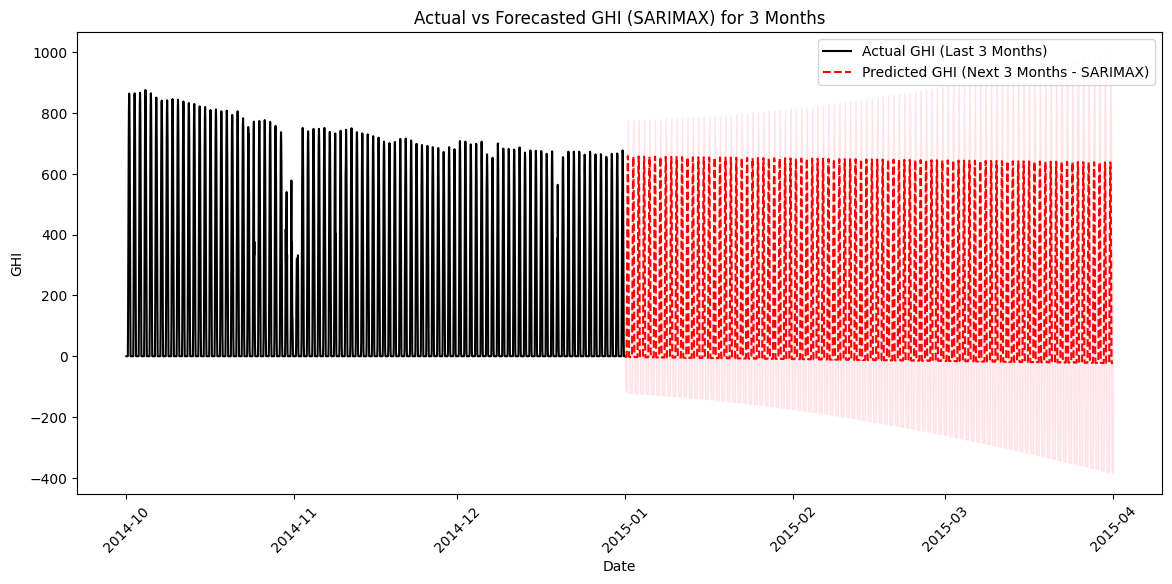

In [5]:


#Sarimax Plot
# Ensure DateTime column is in datetime format
df["DateTime"] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Define target variable for SARIMAX
y = df["GHI"]

# Define SARIMA order based on ACF/PACF and seasonal analysis
sarima_order = (2,1,5)   # ARIMA order (p,d,q)
seasonal_order = (1,1,1,24)  # (P,D,Q,m) -> m=24 for daily seasonality

# Train SARIMAX model
sarimax_model = SARIMAX(y, 
                        order=sarima_order, 
                        seasonal_order=seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
sarimax_model_fit = sarimax_model.fit()

# Get actual data for the last 3 months
start_date = "2014-10-01"
end_date = "2014-12-31"
actual_df = df.loc[start_date:end_date, ["GHI"]]

# Forecast next 3 months
future_steps = 90 * 24  # Assuming hourly data for 90 days
future_forecast = sarimax_model_fit.get_forecast(steps=future_steps)
predicted_mean = future_forecast.predicted_mean
conf_int = future_forecast.conf_int()

# Create future dates
future_dates = pd.date_range(start=df.index.max(), periods=future_steps, freq="h")

# Create DataFrame for future predictions
future_df = pd.DataFrame({
    "DateTime": future_dates,
    "Predicted_GHI": predicted_mean
})

# ------------------ Plot Actual vs Forecasted ------------------ #
plt.figure(figsize=(14, 6))

# Plot Actual Data (Last 3 Months)
plt.plot(actual_df.index, actual_df["GHI"], label="Actual GHI (Last 3 Months)", color="black")

# Plot Forecasted Data (Next 3 Months)
plt.plot(future_df["DateTime"], future_df["Predicted_GHI"], label="Predicted GHI (Next 3 Months - SARIMAX)", color="red", linestyle="dashed")

# Plot confidence intervals
plt.fill_between(future_df["DateTime"], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.xlabel("Date")
plt.ylabel("GHI")
plt.title("Actual vs Forecasted GHI (SARIMAX) for 3 Months")
plt.legend()
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat


🔹 Model Performance Metrics:
Mean Absolute Error (MAE): 79.7211
R2 score: 0.8641
Mean Squared Error (MSE): 13554.2099
Root Mean Squared Error (RMSE): 116.4225
Mean Absolute Percentage Error (MAPE): nan%


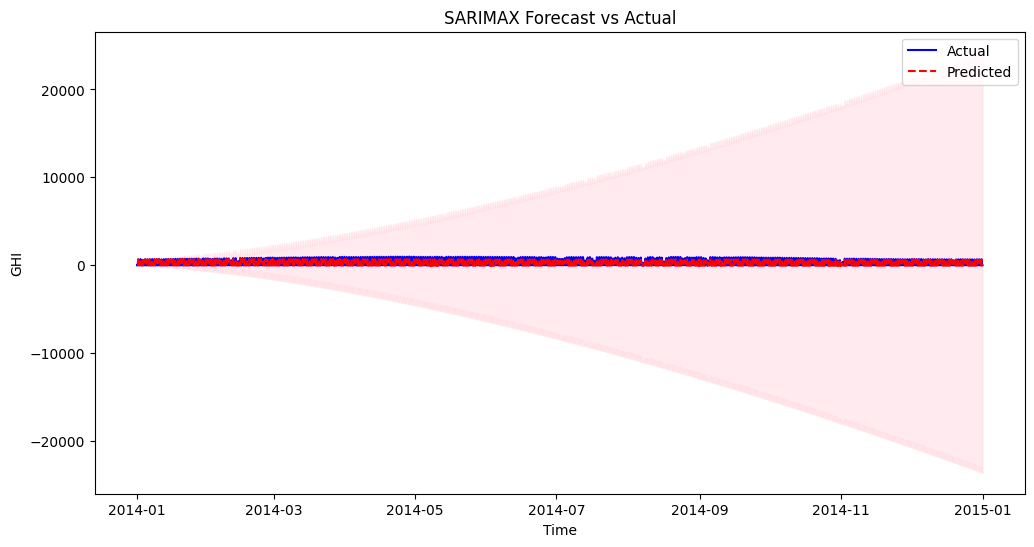

In [6]:
#Sarimax with accuracy
#df["DateTime"] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
#df = df.sort_values(by="DateTime")
#df.set_index("DateTime", inplace=True)

# Define target variable (GHI) and features (Exogenous variables if available)
y = df["GHI"]
X = df.drop(columns=["GHI"])  # Optional: Exogenous variables

# Split Data (80% Train, 20% Test)
split_index = int(len(df) * 0.8)
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]

# Define SARIMAX order
sarima_order = (2,1,5)  # (p,d,q)
seasonal_order = (1,1,1,24)  # (P,D,Q,m), where m=24 (daily seasonality)

X_train = X_train.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')

# Train SARIMAX Model
sarimax_model = SARIMAX(y_train, 
                        exog=X_train,  # Include exogenous variables if available
                        order=sarima_order, 
                        seasonal_order=seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
sarimax_model_fit = sarimax_model.fit()

X_test = X_test.apply(pd.to_numeric, errors='coerce')
# Forecast on test data
future_forecast = sarimax_model_fit.get_forecast(steps=len(y_test), exog=X_test)
predicted_mean = future_forecast.predicted_mean
conf_int = future_forecast.conf_int()  # Confidence interval

# Calculate Accuracy Metrics
mae = mean_absolute_error(y_test, predicted_mean)
mse = mean_squared_error(y_test, predicted_mean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predicted_mean) / y_test.replace(0, np.nan))) * 100  # Avoid division by zero
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
r2 = r2_score(y_test, predicted_mean)  # R² score calculation

# Print Accuracy Metrics
print("\n🔹 Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R2 score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual", color='blue')
plt.plot(y_test.index, predicted_mean, label="Predicted", color='red', linestyle='dashed')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel("Time")
plt.ylabel("GHI")
plt.title("SARIMAX Forecast vs Actual")
plt.legend()
plt.show()
